# Vector Database and Agentic RAG Setup

<img src="./agentic_rag_arch.png" width=600>

# Agentic RAG Setup

In [45]:

from smolagents import OpenAIServerModel, CodeAgent, ToolCallingAgent, HfApiModel, tool, GradioUI
import gradio as gr
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
import fitz  
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb
import os
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import time
import glob
import matplotlib.pyplot as plt
import numpy as np

In [46]:

load_dotenv()

reasoning_model_id = os.getenv("REASONING_MODEL_ID")
tool_model_id = os.getenv("TOOL_MODEL_ID")
huggingface_api_token = os.getenv("HUGGINGFACE_API_TOKEN")
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL")
db_dir = r"D:\2CSI-Project\VectorDB_Embeddings"


In [47]:

def get_model(model_id):
    using_huggingface = os.getenv("USE_HUGGINGFACE", "yes").lower() == "yes"
    if using_huggingface:
        return HfApiModel(model_id=model_id, token=huggingface_api_token)
    else:
        return OpenAIServerModel(
            model_id=model_id,
            api_base="http://localhost:11434/v1",
            api_key="ollama"
        )

# Create the reasoner for better RAG
reasoning_model = get_model(reasoning_model_id)
reasoner = CodeAgent(tools=[], model=reasoning_model, add_base_tools=False, max_steps=2)


In [48]:
#embedding_model = SentenceTransformer(EMBEDDING_MODEL)
# Initialize vector store and embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)
client = chromadb.PersistentClient(path=db_dir)
collection = client.get_or_create_collection(name='ties_collection_emb', metadata={"hnsw:space": "cosine"})

### ---- VectorDB querying ----

In [49]:
def rag_query(query):
    """Retrieves the most relevant document chunks from the vector database."""
    results = collection.query(query_texts=[query], n_results=3)

    if "documents" not in results or not results["documents"]:
        return []

    retrieved_docs = results["documents"][0]  # List of relevant chunk texts

    # Convert to document-like objects
    class Document:
        def __init__(self, content):
            self.page_content = content

    return [Document(doc) for doc in retrieved_docs]

### ---- PDF Processing and Chunking ----

In [50]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

def process_pdf(file_path):
    """Extracts text from a PDF, splits into chunks, and stores them in the vector DB."""
    doc = fitz.open(file_path)
    text = "\n".join([page.get_text("text") for page in doc])

    # text split into chunks
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=800, chunk_overlap=400
    )
    chunks = text_splitter.split_text(text)

    doc_id = os.path.basename(file_path)  #file name as doc_id

    # store chunks in vectorDB
    for i, chunk in enumerate(chunks):
        embedding = embedding_model.encode(chunk).tolist()
        collection.add(
            ids=[f"{doc_id}_chunk_{i}"],  # Unique ID per chunk
            documents=[chunk],
            embeddings=[embedding],
            metadatas=[{"source": doc_id, "chunk_id": i}]
        )

    return f"Processed {len(chunks)} chunks from {doc_id}."

In [6]:
rag_query("machine learning")

Add of existing embedding ID: doc_chunk_0
Add of existing embedding ID: doc_chunk_1
Add of existing embedding ID: doc_chunk_2
Add of existing embedding ID: doc_chunk_3
Add of existing embedding ID: doc_chunk_4
Add of existing embedding ID: doc_chunk_5
Add of existing embedding ID: doc_chunk_6
Add of existing embedding ID: doc_chunk_7
Add of existing embedding ID: doc_chunk_8
Add of existing embedding ID: doc_chunk_9
Add of existing embedding ID: doc_chunk_10
Add of existing embedding ID: doc_chunk_11
Add of existing embedding ID: doc_chunk_12
Add of existing embedding ID: doc_chunk_13
Add of existing embedding ID: doc_chunk_14
Add of existing embedding ID: doc_chunk_15
Add of existing embedding ID: doc_chunk_16
Add of existing embedding ID: doc_chunk_17
Add of existing embedding ID: doc_chunk_18
Add of existing embedding ID: doc_chunk_19
Add of existing embedding ID: doc_chunk_20
Add of existing embedding ID: doc_chunk_21
Add of existing embedding ID: doc_chunk_22
Add of existing embed

[<__main__.rag_query.<locals>.Document at 0x1a9aa4c67b0>,
 <__main__.rag_query.<locals>.Document at 0x1a9ac1abec0>,
 <__main__.rag_query.<locals>.Document at 0x1a9aa5f2c00>]

### # ---- RAG Function  ----

In [51]:
@tool
def rag_with_reasoner(user_query: str) -> str:
    """
    Queries the vector database and uses a reasoning LLM to summarize retrieved content.

    Args:
        user_query (str): The user's question for retrieving relevant document chunks.

    Returns:
        str: A concise summary based on the retrieved chunks.
    """
    docs = rag_query(user_query)

    if not docs:
        return "No relevant context found. Please refine your query."

    # Convert retrieved docs to formatted text
    context = "\n\n".join(doc.page_content for doc in docs)

    prompt = f"""
    You are a scientific paper summarizer. Be concise and specific.
    If there isn't sufficient information, suggest a better query.

    Context:
    {context}

    Question: {user_query}

    Answer:
    """

    # Get response from reasoning model
    response = reasoner.run(prompt, reset=False).split("</think>")[-1].strip()
    return response

In [36]:
print(rag_with_reasoner("Test query"))  # Should return a string

Add of existing embedding ID: doc_chunk_0
Add of existing embedding ID: doc_chunk_1
Add of existing embedding ID: doc_chunk_2
Add of existing embedding ID: doc_chunk_3
Add of existing embedding ID: doc_chunk_4
Add of existing embedding ID: doc_chunk_5
Add of existing embedding ID: doc_chunk_6
Add of existing embedding ID: doc_chunk_7
Add of existing embedding ID: doc_chunk_8
Add of existing embedding ID: doc_chunk_9
Add of existing embedding ID: doc_chunk_10
Add of existing embedding ID: doc_chunk_11
Add of existing embedding ID: doc_chunk_12
Add of existing embedding ID: doc_chunk_13
Add of existing embedding ID: doc_chunk_14
Add of existing embedding ID: doc_chunk_15
Add of existing embedding ID: doc_chunk_16
Add of existing embedding ID: doc_chunk_17
Add of existing embedding ID: doc_chunk_18
Add of existing embedding ID: doc_chunk_19
Add of existing embedding ID: doc_chunk_20
Add of existing embedding ID: doc_chunk_21
Add of existing embedding ID: doc_chunk_22
Add of existing embed

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ You are a scientific paper summarizer. Be concise and specific.                                                 │
│     If there isn't sufficient information, suggest a better query.                                              │
│                                                                                                                 │
│     Context:                                                                                                    │
│     revise Sometimes, the generated candidate queries may con-                                                  │
│ tain syntax errors or produce empty result. In such cases,                                                      │
│ the agent identifies the issue by executing the queries on                                                      │
│ the database and then uses this tool to fix them. This tool                                                     │
│ takes the question, schema, context, the faulty query and a                                                     │
│ description of the issue as input. It then prompts an LLM                                                       │
│ with this information, asking it revise the query. Note that                                                    │
│ the issue description (or execution log) is critical in guiding                                                 │
│ the model, as it provides a direct signal of the query’s failureCHESS: Contextual Harnessing for Efficient SQL  │
│ Synthesis                                                                                                       │
│ point.                                                                                                          │
│ Unit Tester (UT) The Unit Tester (UT) agent is responsible                                                      │
│ for selecting the most accurate SQL query from the pool of                                                      │
│ candidates generated by the CG agent. UT identifies the best                                                    │
│ candidate by 1) generating multiple unit tests that highlight                                                   │
│ differences between the candidate queries and 2) evaluating                                                     │
│ the candidates against these unit tests. It then assigns a score                                                │
│ to each query based on the number of unit tests it passes,                                                      │
│ selecting the top-scoring candidate as the final SQL query                                                      │
│ for the given question.                                                                                         │
│ generate unit test This tool prompts an LLM to generate                                                         │
│ k unit tests, where k is an input parameter, designed such                                                      │
│ that only the correct SQL query can pass each of them. The                                                      │
│ prompt is carefully constructed to produce high-quality unit                                                    │
│ tests that highlight the semantic differences between the                                                       │
│ candidate queries. Detailed prompt used to generate unit                                                        │
│ tests is provided in Appendix C.                                                                                │
│ evaluate After generating the unit tests, the UT agent eval-                                                    │
│ uates the candidate queries against them. This tool ta

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, let me try to figure out how to approach this problem. The task is about finding test instances D that best 
explain whether two SQL queries Q1 and Q2 are equivalent or not. We already have some examples of counterexamples 
where a larger D helps in understanding the difference better.

First, I need to understand what's being asked here. We have two queries Q1 and Q2, and we want to find the 
smallest database D such that when evaluated against both queries, they produce different results. But given the 
problem statement, even finding even one counterexample is a challenge, especially after a large D because students
might not grasp why Q1 and Q2 differ without the right explanation.

So, starting with the example given in the task description. In the TPCAI'07 conference paper, there's an 
experiment where two queries are provided as such:

Q1: select student id from students
Q2: selecting all the student ids of the 'mathematics' students

In this case, D is a set that can have both, and D becomes a problem space because when you evaluate Q1 on it, you 
get all students; when Q2 evaluates only mathematics students. So any tuple in D where the student id isn't from 
'maths' would be a counterexample—showing why the queries aren't equivalent.

But what if we don't know enough to define D? Maybe initially, without specific examples, it's hard to choose what 
D should be. The idea is that different classes of queries guide the selection of D—so if we can narrow down what 
queries are being asked, then perhaps defining D as a test suite for those.

Wait, but the task says "given two arbitrary queries." So maybe there isn't any prior information about Q1 and Q2 
except that they are correct. So without even knowing their structure or behavior, how do we define D?

Hmm, this might be tricky because without specific information on what Q1 and Q2 look like, it's difficult to 
choose the right test instance. Perhaps in the initial problem, the task uses some standard examples to demonstrate
the concept.

Looking at another part of the user message about "Explaining Wrong Queries Using Small Examples" shows how a small
D can be used beyond just counterexamples—maybe also show why they are different for educational purposes.

So, perhaps the goal is to find such minimal subsets (the smallest D) where evaluating Q1 and Q2 on them changes 
their output. This helps in teaching students about why two queries might produce different results without having 
to deal with every possible tuple or instance.

Going back to the problem: Let's say we have two arbitrary but known correct queries, Q1 and Q2. We need to find a 
minimal D such that Q1(D) ≠ Q2(D). Even if no prior structure is given, perhaps we can define D in a way that it 
naturally differentiates them without being over-specified.

Maybe the user didn't provide specific examples but wanted a general approach. So, I think the problem reduces to 
defining a minimal set of records (rows from the database) where the outputs of Q1 and Q2 differ.

But how to construct this minimal D?

Let's think about it step by step.

First, we have two queries Q1 and Q2. Both are correct in an academic context. For example:

Q1: SELECT student_number FROM students
Q2: SELECT STANDOUT(student_NUMBER) FROM students

So both would return all the same student data, just possibly in different orders or with some information added 
(like STANDOUT). A counterexample D is a set of student records that contain both numbers and their standouts. Any 
tuple where the number isn't the same as its standout would be a counterexample.

But suppose we don't have similar queries—maybe one is more complex than the other or has different structures.

Another thought: Maybe if Q1 and Q2 are such that they can only differ when selecting from certain attribut

[Step 1: Duration 45.29 seconds| Input tokens: 2,048 | Output tokens: 2,036]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Sample data                                                                                                    
  row = [                                                                                                          
      {'ID': 1},                                                                                                   
      {                                                                                                            
      'NAME': "Alice"                                                                                              
      }                                                                                                            
  ]                                                                                                                
                                                                                                                   
  # Output as expected                                                                                             
  print("ID = 1, NAME = Alice")                                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
ID = 1, NAME = Alice

Out: None

[Step 2: Duration 6.82 seconds| Input tokens: 4,096 | Output tokens: 2,437]

Reached max steps.

[Step 3: Duration 24.64 seconds| Input tokens: 6,144 | Output tokens: 3,606]

To effectively test various SQL queries, consider the following strategies:

1. **Understand Query Context**: Determine if "test query" pertains to debugging individual queries (including edge cases) or validating query behavior within an application.

2. **Use Appropriate Datasets**: Vary datasets across different data types and structures (e.g., text, numbers, objects) to cover all relevant scenarios.

3. **Execution Methods**: Test queries in environments that include both local, serverless systems and global contexts to account for production variability.

4. **Replication Considerations**: Ensure tests cover replication strategies if applicable, as real-world applications may require redundancy or scaling.

5. **Design Decision-Making**: Address design decisions (e.g., database normalization, function handling) by considering how they affect test outcomes.

6. **Data Input Types**: Use parameters like `@table`, `@year`, and `@id` to test specific functionality while preventing iss

In [52]:
tool_model = get_model(tool_model_id)
primary_agent = ToolCallingAgent(tools=[rag_with_reasoner], model=tool_model, add_base_tools=False, max_steps=5)


def main():
    with gr.Blocks(theme=gr.themes.Soft(), title="📖 Paperly") as interface:
        gr.HTML("<link rel='icon' href='assets/paperly.png' type='image/png'>")
        gr.Markdown("# 📚 Agentic RAG for Scientific Papers")
        gr.Markdown("Upload a PDF and ask questions to retrieve key insights.")

        with gr.Row():
            with gr.Column():
                pdf_upload = gr.File(label="📄 Upload PDF", type="filepath")
                process_btn = gr.Button("📥 Process PDF")
                process_output = gr.Textbox(label="Processing Status", interactive=False)

            with gr.Column():
                user_input = gr.Textbox(label="🔍 Ask a Question", placeholder="Summarize this paper in 200 words...")
                submit_btn = gr.Button("🔎 Retrieve & Summarize")
                output_box = gr.Textbox(label="📜 Summary", interactive=False)

        process_btn.click(fn=process_pdf, inputs=pdf_upload, outputs=process_output)
        submit_btn.click(fn=rag_with_reasoner, inputs=user_input, outputs=output_box)

    interface.launch(
        share=True,
        inbrowser=True,
        server_name="127.0.0.1",
        favicon_path="assets/paperly.png",
    )

if __name__ == "__main__":
    main()

* Running on local URL:  http://127.0.0.1:7871


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "c:\Users\anacond


Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "c:\Users\anacond

### Models Evaluations

In [15]:

# Folder path containing PDFs
pdf_folder = r"C:\Users\ACER NITRO\OneDrive\Bureau\2CSI\Project 2SCI\Automated-Information-Retrieval-and-Summarization-for-Academic-Research-Articles\RAG_Models(notebooks)\DAIT_DEHANE_Yacine\Agentic_RAG_deepseek\data"

# Function for Classical RAG (using the reasoning model)
def classical_rag_summary(query: str) -> str:
    return reasoner.run(query)  # Using the reasoner to generate summaries

# Load your models
def agentic_rag_summary(query):
    return rag_with_reasoner(query)  # Uses your RAG agent

def deepseek_summary(query):
    return reasoner.run(query, reset=False)  # DeepSeek 1.5 response

# Extract text from the first 1000 characters (approx. abstract)
def extract_abstract(pdf_path):
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    return text[:1000]  # First 1000 chars as ground truth summary

# Compute BLEU score
def compute_bleu(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    return sentence_bleu(reference_tokens, candidate_tokens)

# Compute ROUGE scores
def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)

# Find all PDFs in the folder
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

# Evaluate on all PDFs
# Store results
bleu_scores = {"Agentic_RAG": [], "DeepSeek": []}
rouge_scores = {"Agentic_RAG": {"rouge1": [], "rouge2": [], "rougeL": []}, 
                "DeepSeek": {"rouge1": [], "rouge2": [], "rougeL": []}}

# Evaluation loop
for pdf in pdf_files:
    print(f"Processing {pdf}...")

    # Extract reference summary
    reference_summary = extract_abstract(pdf)

    # summary generation
    query = "Summarize this paper in 200 words."
    agentic_summary = agentic_rag_summary(query)
    deepseek_summary_text = deepseek_summary(query)

    # Compute BLEU & ROUGE
    bleu_rag = compute_bleu(reference_summary, agentic_summary)
    rouge_rag = compute_rouge(reference_summary, agentic_summary)

    bleu_deepseek = compute_bleu(reference_summary, deepseek_summary_text)
    rouge_deepseek = compute_rouge(reference_summary, deepseek_summary_text)

    # Store results
    bleu_scores["Agentic_RAG"].append(bleu_rag)
    bleu_scores["DeepSeek"].append(bleu_deepseek)

    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["Agentic_RAG"][key].append(rouge_rag[key].fmeasure)
        rouge_scores["DeepSeek"][key].append(rouge_deepseek[key].fmeasure)

    time.sleep(2)

# Print final evaluation results
for model, scores in results.items():
    avg_bleu = sum(s["BLEU"] for s in scores) / len(scores)
    avg_rouge1 = sum(s["ROUGE"]["rouge1"].fmeasure for s in scores) / len(scores)
    avg_rouge2 = sum(s["ROUGE"]["rouge2"].fmeasure for s in scores) / len(scores)
    avg_rougeL = sum(s["ROUGE"]["rougeL"].fmeasure for s in scores) / len(scores)

    print(f"\n🔷 {model} Performance:")
    print(f"   🟢 Avg BLEU: {avg_bleu:.4f}")
    print(f"   🟢 Avg ROUGE-1: {avg_rouge1:.4f}")
    print(f"   🟢 Avg ROUGE-2: {avg_rouge2:.4f}")
    print(f"   🟢 Avg ROUGE-L: {avg_rougeL:.4f}")


Processing C:\Users\ACER NITRO\OneDrive\Bureau\2CSI\Project 2SCI\Automated-Information-Retrieval-and-Summarization-for-Academic-Research-Articles\RAG_Models(notebooks)\DAIT_DEHANE_Yacine\Agentic_RAG_deepseek\data\38_1612851.pdf...


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ You are a scientific paper summarizer. Be concise and specific.                                                 │
│     If there isn't sufficient information, suggest a better query.                                              │
│                                                                                                                 │
│     Context:                                                                                                    │
│     2019. IEEE. ISBN 978-1-72811-760-7. doi:10.1109/ICSE-SEIP.2019.00039. URL https://ieeexplore.ieee.          │
│ org/document/8804442/.                                                                                          │
│ Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri         │
│ Edwards,                                                                                                        │
│ Yuri Burda, Nicholas Joseph, Greg Brockman, Alex Ray, Raul Puri, Gretchen Krueger, Michael Petrov, Heidy        │
│ Khlaaf, Girish Sastry, Pamela Mishkin, Brooke Chan, Scott Gray, Nick Ryder, Mikhail Pavlov, Alethea Power,      │
│ Lukasz Kaiser, Mohammad Bavarian, Clemens Winter, Philippe Tillet, Felipe Petroski Such, Dave Cummings,         │
│ Matthias Plappert, Fotios Chantzis, Elizabeth Barnes, Ariel Herbert-V oss, William Hebgen Guss, Alex Nichol,    │
│ Alex                                                                                                            │
│ Paino, Nikolas Tezak, Jie Tang, Igor Babuschkin, Suchir Balaji, Shantanu Jain, William Saunders, Christopher    │
│ Hesse, Andrew N. Carr, Jan Leike, Josh Achiam, Vedant Misra, Evan Morikawa, Alec Radford, Matthew Knight,       │
│ Miles Brundage, Mira Murati, Katie Mayer, Peter Welinder, Bob McGrew, Dario Amodei, Sam McCandlish,             │
│ Ilya Sutskever, and Wojciech Zaremba. Evaluating Large Language Models Trained on Code, July 2021. URL          │
│ http://arxiv.org/abs/2107.03374. arXiv:2107.03374 [cs\].                                                        │
│ Marietjie Botes and Gabriele Lenzini. When cryptographic ransomware poses cyber threats: Ethical chal-          │
│ lenges and proposed safeguards for cybersecurity researchers. In 2022 IEEE European Symposium on                │
│ Security and Privacy Workshops (EuroS&PW) , pages 562–568. IEEE, 2022. ISBN 978-1-66549-560-8.                  │
│ doi:10.1109/EuroSPW55150.2022.00067. URL https://ieeexplore.ieee.org/document/9799383/.                         │
│ Daya Guo, Qihao Zhu, Dejian Yang, Zhenda Xie, Kai Dong, Wentao Zhang, Guanting Chen, Xiao Bi, Y . Wu, Y . K.    │
│ Li,                                                                                                             │
│ Fuli Luo, Yingfei Xiong, and Wenfeng Liang. DeepSeek-coder: When the large language model meets programming     │
│ – the rise of code intelligence, 2024. URL https://arxiv.org/abs/2401.14196. Version Number: 2.                 │
│ Llama 2: Open foundation and fine-tuned chat models, 2023. URL https://arxiv.org/abs/2307.09288. Version        │
│ Number: 2.                                                                                                      │
│ Leo Gao, Jonathan Tow, Baber Abbasi, Stella Biderman, Sid Black, Anthony DiPofi, Charles Foster, Laurence       │
│ Golding, Jeffrey Hsu, Alain Le Noac’h, Haonan Li, Kyle McDonell, Niklas Muennighoff, Chris Ociepa, Jason        │
│ Phang, Laria Reynolds, Hailey Schoelkopf, Aviya Skowron, Lintang Sutawika, Eric Tang, Anish Thite, Ben Wang,    │
│ Kevin Wang, and Andy Zou. A framework for few-shot language model evaluation, December 2023. URL                │
│                                                       

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Alright, so I need to sum up this paper titled "Summarizing Community-Based Question-Answer Pairs". Let me start by
reading through it carefully to understand the main points.

The abstract mentions that this is a novel approach for learning embeddings from community-based Q&A pairs. The 
method involves combining token-level, word-level, and sentence-level embeddings using transformer models. They 
also introduce a weighted sum of these embeddings while preserving certain properties, resulting in 
lower-dimensional vectors than typical embeddings. This is achieved through contrastive learning.

The paper goes on to build a model that generates such embeddings adaptively as the dataset grows. It uses 
attention layers within a multi-modal self-attention module for each sample and processes tokens with transformer 
modules. The effectiveness of this approach was tested against standard benchmarks like CLRSQTL and ACR, achieving 
reasonable performance. They also mention applying this method to real-world Q&A systems.

Looking at the introduction, they explain how traditional embedding methods capture only specific features from 
text data. Community-based pairs provide a context-rich view, so their work emphasizes capturing broader knowledge 
from such interactions. The target is to address these limitations by enabling models to learn more comprehensive 
embeddings.

In summary, the paper presents an adaptive embedding method for community-based Q&A pairs, using various levels of 
tokens and multi-modal attention within transformer frameworks. It shows promising performance in benchmarks but 
needs testing on real systems like Sissie Hsiao's Twitter Q&A. However, without concrete results yet from practical
application, it might be premature to summarize further.

I need to make sure I haven't missed any details. Let me quickly check the abstract again: Yes, they're introducing
an embedding method that captures community-level interactions by combining different token and level features. The
model is contrastive in nature, using embeddings at multiple levels with attention modules for alignment. Good, 
that's what I thought from the summary.

I think I've covered all the key points. Now, to structure this into a concise 200-word summary.
</think>

The paper introduces an adaptive embedding method using community-based question-answer pairs. Instead of focusing 
only on specific features, the approach captures context-rich information through multiple token and level 
embeddings. These are combined via contrastive learning within a multi-modal self-attention module, leading to 
lower-dimensional vectors than typical embeddings. Tested against benchmarks like CLRSQTL and ACR, the method shows
reasonable results but lacks direct real-world Q&A system application yet. The work targets expanding embedding 
capabilities by considering community-level interactions for broader knowledge capture.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 18: Duration 37.18 seconds| Input tokens: 36,310 | Output tokens: 9,808]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Alright, I need to sum up this paper titled "Summarizing Community-Based Question-Answer Pairs." Let me start by 
reading through it carefully. The abstract mentions that this is a novel approach for learning embeddings from 
community-based Q&A pairs. It combines token-level, word-level, and sentence-level embeddings using transformer 
models. They introduce a weighted sum of these embeddings while preserving certain properties, resulting in 
lower-dimensional vectors than typical embeddings. This is achieved through contrastive learning.

The paper then explains how the model uses attention layers within a multi-modal self-attention module for each 
sample. It processes tokens with transformer modules and generates adaptive embeddings as the dataset grows. The 
effectiveness was tested against standard benchmarks like CLRSQTL and ACR, achieving reasonable performance. They 
also mention applying this method to real-world Q&A systems.

In summary, the paper presents an adaptive embedding method for community-based Q&A pairs using multiple token 
types and attention modules within transformer frameworks. It shows potential through theoretical analysis but 
lacks direct real-world application yet.

The key takeaway is that this approach uses multiple levels of tokens from questions and answers and employs 
attention mechanisms to align important parts across different representations, leading to contextualized 
embeddings.
Make sure you've covered all the points clearly in your summary.
Now go ahead and provide a concise 200-word summary without repeating any details.

Thoughts: I need to ensure clarity and conciseness when summarizing. Let me focus on the main contributions and 
findings of the paper.
Alright, I think this covers everything succinctly. Time to put it all together neatly.
Now let's proceed to present this as a proper summary.
Here goes:
The paper introduces an adaptive embedding method for community-based Q&A pairs that uses token-level, word-level, 
and sentence-level embeddings in contrastive learning with attention mechanisms within a multi-modal self-attention
framework. This approach generates lower-dimensional contextualized embeddings that capture both individual 
knowledge and context. Through extensive testing on established benchmarks, the model demonstrates reasonable 
performance, suggesting potential benefits for real-world Q&A systems but requiring further empirical validation.
Makesense! Make sure to frame your summary in this logical structure using formal language.

Now proceed with the actual summary in a well-structured manner.
The paper proposes an embedding method for community Q&A pairs through multiple token levels and contrastive 
learning, utilizing attention within multi-modal transformers. This produces lower-dimensional contextual 
embeddings that balance individual knowledge and context. Testing on benchmarks shows promise but requires real 
system applications for further validation.
Cool, you've got the key ideas in order. Time to make a perfect summary with all these points covered clearly.
Alright, here's how I'd structure it.
But wait, I should also include information about the method being contrastive and using weighted sums, focusing on
adaptability as the dataset grows.

To recap:
- Combines multiple token types (entity-level, individual-level).
- Uses contrastive learning across different modals.
- Implements attention modules for aligning embeddings.
- Generates lower-dimensional vectors than typical.
This approach aims to capture context-rich information from community-based interactions, leading to more accurate 
and nuanced models. It shows potential in real-world systems but requires further practical application and 
validation against actual Q&A architectures.
Makes sense! I think this captures all essen

[Step 19: Duration 44.93 seconds| Input tokens: 38,358 | Output tokens: 10,782]

Reached max steps.

[Step 20: Duration 69.72 seconds| Input tokens: 40,406 | Output tokens: 11,336]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Summarize this paper in 200 words.                                                                              │
│                                                                                                                 │
╰─ OpenAIServerModel - deepseek-r1:1.5b ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, so I need to summarize this paper into 200 words. Let me start by reading through the provided text 
carefully.

The user has shared some tasks and examples where they have used various tools. For instance, they searched for 
information, used dictionaries or web search functions, etc. The task here is a new one: summarizing a specific 
paper in 200 words. 

I don't have access to the exact content of that particular paper mentioned. So, I'll need to discuss how one would
approach summarizing such a paper and list the steps involved.

First, understanding the structure of a summary. Usually, summaries include an abstract, introduction, methodology,
key findings, conclusion, and references or citations. 

Since there's no specific content, I'll outline the process that any summarizer would follow. They would start by 
reading through the full text to get an overview, identify main arguments or conclusions first.

Then, they'd break down the paper into sections like introduction, methodology, results, discussion, conclusion, 
etc., and write in a clear, concise manner without going into too much detail that's not relevant.

I should make sure the summary is around 200 words, so each section shouldn't be too long. Also, I'll need to 
mention that sometimes summaries don't cover every detail of the original text but provide an overview based on the
sources.

But since I don't have the exact content, I can only describe what would be included and avoid mentioning specifics
from the paper.
</think>

To summarize a research paper effectively, follow these steps:

1. **Read Openly:** Begin by skimming through the full text to grasp the overall theme and key points.
2. **Identify Abstract:** Look for an abstract that summarizes the study's purpose, methodology, results, and 
conclusions.
3. **Outline Key Sections:** Note down main sections such as introduction, methodology, findings, discussion, and 
conclusion.
4. **Focus on Clarity:** Aim to express ideas concisely without delving into peripheral information.
5. **Citations and References:** Ensure proper attribution by including the reference in-text or at the end if 
needed.

A typical summary might include an abstract, introduction explaining the purpose, methodology detailing how data 
was collected or analyzed, key findings that highlight main results, an expanded discussion interpreting these 
results, a brief conclusion, and references to support claims. This approach provides an overview while maintaining
readability.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 21: Duration 22.49 seconds| Input tokens: 42,450 | Output tokens: 11,833]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Alright, so I'm looking for a way to summarize the given paper in 200 words. First, I'll need to understand its 
main themes and key points. From what's provided, it seems to focus on data analysis using Python, specifically 
data from Wikipedia articles. 

The paper introduces tools like `wiki` which parses Wikipedia URLs, but also mentions limitations such as relying 
purely on public data. It discusses the importance of source credibility, suggesting that reliance solely on 
publicly available information is problematic.

To sum this up succinctly:
1. Data analysis using Wikipedia articles.
2. Tools: `py`, `time`, `statistics`.
3. Key points: tools from `py` and `time` for parsing data in the form of tuples with URL, title, and content.
4. Limitations: Rely on public data without verifying sources.
5. Conclusion: The challenge is balancing analysis with proper source credibility, which requires more than just 
scraping public content alone.

I need to keep each section concise but informative. Let me structure it as an introduction, methodology, key 
findings, limitations, and conclusion, ensuring clarity while maintaining accuracy based on the provided text.
</think>

The paper discusses the use of Python tools for parsing data from Wikipedia articles in the form of tuples 
containing URL, title, and content. It introduces functions such as `parse_wiki`, but emphasizes that public 
sources may lack source credibility. Key findings include the need to verify sources without solely scraping public
data. Limitations are noted regarding reliance on publicly available information alone. The study highlights the 
challenge of balancing analysis with proper source credibility. In conclusion, the importance of verifying sources 
is underscored, suggesting an increase in focus on more rigorous methods than just scraping public content.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 22: Duration 16.73 seconds| Input tokens: 44,498 | Output tokens: 12,187]

Reached max steps.

[Step 23: Duration 35.09 seconds| Input tokens: 46,538 | Output tokens: 12,579]

c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Processing C:\Users\ACER NITRO\OneDrive\Bureau\2CSI\Project 2SCI\Automated-Information-Retrieval-and-Summarization-for-Academic-Research-Articles\RAG_Models(notebooks)\DAIT_DEHANE_Yacine\Agentic_RAG_deepseek\data\39_3323796.pdf...


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ You are a scientific paper summarizer. Be concise and specific.                                                 │
│     If there isn't sufficient information, suggest a better query.                                              │
│                                                                                                                 │
│     Context:                                                                                                    │
│     2019. IEEE. ISBN 978-1-72811-760-7. doi:10.1109/ICSE-SEIP.2019.00039. URL https://ieeexplore.ieee.          │
│ org/document/8804442/.                                                                                          │
│ Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri         │
│ Edwards,                                                                                                        │
│ Yuri Burda, Nicholas Joseph, Greg Brockman, Alex Ray, Raul Puri, Gretchen Krueger, Michael Petrov, Heidy        │
│ Khlaaf, Girish Sastry, Pamela Mishkin, Brooke Chan, Scott Gray, Nick Ryder, Mikhail Pavlov, Alethea Power,      │
│ Lukasz Kaiser, Mohammad Bavarian, Clemens Winter, Philippe Tillet, Felipe Petroski Such, Dave Cummings,         │
│ Matthias Plappert, Fotios Chantzis, Elizabeth Barnes, Ariel Herbert-V oss, William Hebgen Guss, Alex Nichol,    │
│ Alex                                                                                                            │
│ Paino, Nikolas Tezak, Jie Tang, Igor Babuschkin, Suchir Balaji, Shantanu Jain, William Saunders, Christopher    │
│ Hesse, Andrew N. Carr, Jan Leike, Josh Achiam, Vedant Misra, Evan Morikawa, Alec Radford, Matthew Knight,       │
│ Miles Brundage, Mira Murati, Katie Mayer, Peter Welinder, Bob McGrew, Dario Amodei, Sam McCandlish,             │
│ Ilya Sutskever, and Wojciech Zaremba. Evaluating Large Language Models Trained on Code, July 2021. URL          │
│ http://arxiv.org/abs/2107.03374. arXiv:2107.03374 [cs\].                                                        │
│ Marietjie Botes and Gabriele Lenzini. When cryptographic ransomware poses cyber threats: Ethical chal-          │
│ lenges and proposed safeguards for cybersecurity researchers. In 2022 IEEE European Symposium on                │
│ Security and Privacy Workshops (EuroS&PW) , pages 562–568. IEEE, 2022. ISBN 978-1-66549-560-8.                  │
│ doi:10.1109/EuroSPW55150.2022.00067. URL https://ieeexplore.ieee.org/document/9799383/.                         │
│ Daya Guo, Qihao Zhu, Dejian Yang, Zhenda Xie, Kai Dong, Wentao Zhang, Guanting Chen, Xiao Bi, Y . Wu, Y . K.    │
│ Li,                                                                                                             │
│ Fuli Luo, Yingfei Xiong, and Wenfeng Liang. DeepSeek-coder: When the large language model meets programming     │
│ – the rise of code intelligence, 2024. URL https://arxiv.org/abs/2401.14196. Version Number: 2.                 │
│ Llama 2: Open foundation and fine-tuned chat models, 2023. URL https://arxiv.org/abs/2307.09288. Version        │
│ Number: 2.                                                                                                      │
│ Leo Gao, Jonathan Tow, Baber Abbasi, Stella Biderman, Sid Black, Anthony DiPofi, Charles Foster, Laurence       │
│ Golding, Jeffrey Hsu, Alain Le Noac’h, Haonan Li, Kyle McDonell, Niklas Muennighoff, Chris Ociepa, Jason        │
│ Phang, Laria Reynolds, Hailey Schoelkopf, Aviya Skowron, Lintang Sutawika, Eric Tang, Anish Thite, Ben Wang,    │
│ Kevin Wang, and Andy Zou. A framework for few-shot language model evaluation, December 2023. URL                │
│                                                       

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, so I have to summarize this paper from 2004 about LexRank and text summarization. I'm not very familiar with 
computational linguistics or NLP, but I want to give it a fair shot. Let me start by reading through the abstract 
first because it gives a quick overview.

The abstract mentions that LexRank is an algorithm designed for finding textual salience. Salience here probably 
means how important something is in the text. LexRank scores words based on their context, which makes the most out
of word usage and co-occurrence with other relevant terms. So it's not just about the number of times a word pops 
up but where else those words appear around it.

In the context of this paper, LexRank is used to score sentence-level salience for text summarization. That means 
the algorithm looks at whole sentences and determines which ones are the most informative or carry the most 
information. The authors tested this on datasets like Amazon books and Wikipedia articles and compared LexRank's 
performance against other methods.

They also mentioned that their method produced competitive results, meaning it didn't just beat everyone but 
actually performed well in real-world applications. High-frequency words like "the" were still valued because 
they're fundamental, which makes sense. And there is room for improvement because there might be more optimization 
to make LexRank even better or faster.

Now, thinking about how I would approach summarizing this. First, I need a clear outline of the key points: what 
LexRank does ( scoring word and sentence salience ), its application in text summarization, datasets tested, and 
findings.

I know that some terms might have been a bit technical when I first read it, especially things like graph-based 
scores for word and sentence. Maybe I should look up what graph-based ranking is to better understand the 
underlying mechanism. But since this is a summary, maybe just noting that without delving too much would be okay.

I should also consider if there are other similar methods or related algorithms out there that did text 
summarization before 2004. Maybe the approach by Getmano's "ScoreIt" model? I'm not sure about that one, but it's 
good to think about alternative methods and how LexRank stands against them.

Overall, the point is that LexRank provides a way to determine which sentences or text chunks are most valuable for
summarizing a document. It helps in focusing on the key points without redundancy, making the summary more 
efficient.

I should check if I've included all the important parts from the abstract: the algorithm's name (LexRank), how it 
works (text and sentence scoring via word co-occurrence), its application in text summarization challenges, the 
datasets used, their results (competitive performance), the role of high-frequency words, potential for 
optimization. 

I think I've covered that well without getting too bogged down with specific terms from 2004, since the paper is 
foundational and now maybe more standardized.

Alright, time to put it all together into a concise summary.
</think>

The paper introduces LexRank, an algorithm designed to assess textual salience for text summarization. Here's a 
structured summary:

- **Algorithm Overview**: LexRank evaluates word and sentence salience by considering their co-occurrence and 
context within the text. It scores words based on how relevant they are to surrounding content.

- **Text Summarization Challenges**: The paper addresses identifying the most informative sentences or parts of the
text for a concise summary.

- **Datasets and Results**: Tested on Amazon books, Wikipedia articles, and Wikipedia pages, LexRank demonstrated 
competitive performance. Its effectiveness varied slightly with dataset size but overall comparable to other 
methods.

- **Hi

[Step 24: Duration 38.43 seconds| Input tokens: 48,586 | Output tokens: 13,415]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Your python code here                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 25: Duration 25.29 seconds| Input tokens: 50,634 | Output tokens: 13,887]

Reached max steps.

[Step 26: Duration 29.88 seconds| Input tokens: 52,682 | Output tokens: 13,943]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Summarize this paper in 200 words.                                                                              │
│                                                                                                                 │
╰─ OpenAIServerModel - deepseek-r1:1.5b ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, so I have to summarize this paper into 200 words. The user provided a detailed task but now has the paper's 
summary: "A novel deep learning architecture for text classification using graph neural networks." Let me break 
this down step by step.

First, I'll identify the key elements in the paper. The main contribution is a deep learning model optimized with 
graph neural networks (GNN) for classifying text data. The structure likely includes layers processing different 
nodes in a graph representation of words or sentences.

Next, I need to outline the approach. Graph Neural Networks (GNNs) are good for handling structural data like 
sentences, where information is interconnected. Deep learning adds flexibility and effectiveness through multiple 
layers. So the model probably starts by embedding word or sentence representations using GNNs and then applies a 
deep neural network on top to capture hierarchical patterns.

The limitations? Well, I'm not sure if they mention computational costs or specific datasets used. Also, the 
architecture size could be a point of discussion. How many layers, nodes? Maybe it's limited by current hardware 
resources compared to traditional approaches like CNNs.

Contributions: The user expects 200 words, which I can't reach yet. They'll have to include the novel deep learning
model and GNN integration as contributions.

Looking ahead, when presenting this summary, potential issues could be referencing too new or limited datasets. 
Also, explaining computational feasibility in future discussions might hinder clarity, but that's acceptable once 
more refined.

Perhaps adding a roadmap of applications would help guide the audience on where this model can be used. Time 
investment is important to mention, and alternative contributions like multi-modal models could show broader 
impact.
</think>

**Key Contributions:**
- **Model Development:** A novel deep learning architecture optimized with graph neural networks (GNN) for text 
classification tasks.
- **Graph Neural Networks (GNN):** Emphasis on GNNs integrating network structures to process sequential data 
effectively.

**Architecture and Structure:**  
- Embeds word/sentence representations using GNN, capturing structured data's inherent relationships.
- Transitions through multiple layers, enhancing feature representation hierarchy in text classification.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 27: Duration 20.24 seconds| Input tokens: 54,726 | Output tokens: 14,382]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Alright, I need to figure out what the user is trying to achieve. They've provided some detailed instructions and 
even shared a paper snippet. The task is to summarise this text into 200 words, but there seem to be some issues in
the initial prompt.

First, looking at the content of the paper snippet: "A novel deep learning architecture for text classification 
using graph neural networks." So, it's presenting a new model that uses GNNs for deep learning tasks on text data. 
The challenge here could be discussing how much I can contribute within 200 words, given the complexity and current
knowledge in fields like machine learning and natural language processing.

But wait, I notice that the user has already started explaining the concept but hasn't formulated a concrete 
question yet. Maybe after more discussions or writing, they'd have clearer next steps to expand on their summary.

Still, sticking to the task as given, I'll outline my understanding:
- The paper introduces a model combining deep learning with graph neural networks for text classification.
- Graph neural networks are good at handling interconnected data structures like sentences or documents.
- Deep learning offers flexibility and effectiveness through multiple layers.
- Highlighting the integration of these two approaches would be key.

I need to ensure that my thought process doesn't include any errors related to the regular message, which mentions 
issues with regex patterns being invalid due to incorrect delimiters. I'll focus on accurately summarizing and 
explaining without trying to proceed further in their intended direction.

In summary, while the task presents some technical challenges in formulating a clear and concise summary, I can 
provide an accurate and comprehensive overview of the paper's main contributions, model architecture, and potential
applications.
</think>

Now let me rewrite my response for better clarity:  
- The paper introduces a novel deep learning model that uses graph neural networks (GNNs) for text classification 
tasks.  
- GNNs are effective at processing interconnected data structures like sentences or documents by embedding 
word/sentence representations within network nodes.  
- The proposed model combines deep learning with GNNs to achieve hierarchical feature representations, enhancing 
the model's ability to capture structural relationships in text data.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 28: Duration 20.26 seconds| Input tokens: 56,774 | Output tokens: 14,821]

Reached max steps.

[Step 29: Duration 34.89 seconds| Input tokens: 58,819 | Output tokens: 15,089]

c:\Users\anaconda3\envs\SEDS_ML\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Processing C:\Users\ACER NITRO\OneDrive\Bureau\2CSI\Project 2SCI\Automated-Information-Retrieval-and-Summarization-for-Academic-Research-Articles\RAG_Models(notebooks)\DAIT_DEHANE_Yacine\Agentic_RAG_deepseek\data\40_568165.pdf...


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ You are a scientific paper summarizer. Be concise and specific.                                                 │
│     If there isn't sufficient information, suggest a better query.                                              │
│                                                                                                                 │
│     Context:                                                                                                    │
│     2019. IEEE. ISBN 978-1-72811-760-7. doi:10.1109/ICSE-SEIP.2019.00039. URL https://ieeexplore.ieee.          │
│ org/document/8804442/.                                                                                          │
│ Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri         │
│ Edwards,                                                                                                        │
│ Yuri Burda, Nicholas Joseph, Greg Brockman, Alex Ray, Raul Puri, Gretchen Krueger, Michael Petrov, Heidy        │
│ Khlaaf, Girish Sastry, Pamela Mishkin, Brooke Chan, Scott Gray, Nick Ryder, Mikhail Pavlov, Alethea Power,      │
│ Lukasz Kaiser, Mohammad Bavarian, Clemens Winter, Philippe Tillet, Felipe Petroski Such, Dave Cummings,         │
│ Matthias Plappert, Fotios Chantzis, Elizabeth Barnes, Ariel Herbert-V oss, William Hebgen Guss, Alex Nichol,    │
│ Alex                                                                                                            │
│ Paino, Nikolas Tezak, Jie Tang, Igor Babuschkin, Suchir Balaji, Shantanu Jain, William Saunders, Christopher    │
│ Hesse, Andrew N. Carr, Jan Leike, Josh Achiam, Vedant Misra, Evan Morikawa, Alec Radford, Matthew Knight,       │
│ Miles Brundage, Mira Murati, Katie Mayer, Peter Welinder, Bob McGrew, Dario Amodei, Sam McCandlish,             │
│ Ilya Sutskever, and Wojciech Zaremba. Evaluating Large Language Models Trained on Code, July 2021. URL          │
│ http://arxiv.org/abs/2107.03374. arXiv:2107.03374 [cs\].                                                        │
│ Marietjie Botes and Gabriele Lenzini. When cryptographic ransomware poses cyber threats: Ethical chal-          │
│ lenges and proposed safeguards for cybersecurity researchers. In 2022 IEEE European Symposium on                │
│ Security and Privacy Workshops (EuroS&PW) , pages 562–568. IEEE, 2022. ISBN 978-1-66549-560-8.                  │
│ doi:10.1109/EuroSPW55150.2022.00067. URL https://ieeexplore.ieee.org/document/9799383/.                         │
│ Daya Guo, Qihao Zhu, Dejian Yang, Zhenda Xie, Kai Dong, Wentao Zhang, Guanting Chen, Xiao Bi, Y . Wu, Y . K.    │
│ Li,                                                                                                             │
│ Fuli Luo, Yingfei Xiong, and Wenfeng Liang. DeepSeek-coder: When the large language model meets programming     │
│ – the rise of code intelligence, 2024. URL https://arxiv.org/abs/2401.14196. Version Number: 2.                 │
│ Llama 2: Open foundation and fine-tuned chat models, 2023. URL https://arxiv.org/abs/2307.09288. Version        │
│ Number: 2.                                                                                                      │
│ Leo Gao, Jonathan Tow, Baber Abbasi, Stella Biderman, Sid Black, Anthony DiPofi, Charles Foster, Laurence       │
│ Golding, Jeffrey Hsu, Alain Le Noac’h, Haonan Li, Kyle McDonell, Niklas Muennighoff, Chris Ociepa, Jason        │
│ Phang, Laria Reynolds, Hailey Schoelkopf, Aviya Skowron, Lintang Sutawika, Eric Tang, Anish Thite, Ben Wang,    │
│ Kevin Wang, and Andy Zou. A framework for few-shot language model evaluation, December 2023. URL                │
│                                                       

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>

</think>

Certainly, I can summarize the paper in about 200 words based on its abstract and key findings. The manuscript 
introduces an efficient attention mechanism specifically designed for long document summarization tasks. Here's a 
concise summary:

Document summarization has become increasingly important with the rise of big data. This process involves 
generating concise summaries from lengthy texts by identifying, extracting, and contextualizing significant 
information. In this paper, we address the challenge of efficiently summarizing long documents, which are prevalent
in various applications such as academic writing, policy-making, and web browsing. 

Traditional attention mechanisms based on frequency scoring and position have been optimized for short text with 
low-length features but lack effectiveness when applied to long texts with numerous high-frequency words. We 
propose an innovative approach that leverages both the textual content and contextual information extracted from 
neighboring sentences in documents. Our experimental results demonstrate significant improvements in capturing the 
nuances of high-frequency words, such as state-of-the-art frequency-based attention mechanisms.

In summary, this paper provides a promising direction for more effective long document summarization by building on
existing features while introducing novel ones that address the limitations of traditional methods. The proposed 
approach could lead to better outcomes in generating precise summaries from both short and long documents.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 30: Duration 14.73 seconds| Input tokens: 60,867 | Output tokens: 15,339]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>

To solve the task, I need to compute 88 raised to the power of 0.36. First, calculate the exponent.

Thought:
The problem is straightforward as it involves calculating an exponential value using known mathematical operations.

Code:

88 ** 0.36
```
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 31: Duration 5.31 seconds| Input tokens: 62,915 | Output tokens: 15,401]

Reached max steps.

[Step 32: Duration 31.18 seconds| Input tokens: 64,963 | Output tokens: 15,913]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Summarize this paper in 200 words.                                                                              │
│                                                                                                                 │
╰─ OpenAIServerModel - deepseek-r1:1.5b ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, so I need to summarize this paper into 200 words. Let me start by reading through what the user provided. 
They have given me some tools for creating thought sequences and code blocks, as well as guidelines on how to 
structure the response. 

Wait, in the previous example, they used the search tool with specific query strings. I think I should follow that 
structure here. The task is about summarizing a paper, but since I don't have access to the content, I'll need to 
outline the key points based on common methodologies or fields related to such summaries.

Hmm, if it's about language models or their role in summarization, that could fit. Maybe the user wrote a query 
using 'wikipedia' for search results. Let me try to break down the example again but make sure I'm following the 
guidelines properly. Make sure each thought is sequential and each tool is used correctly without repetition or 
unnecessary chain calls.

I should also keep track of variables defined earlier, like 'answer', which holds any intermediate results. But 
since this task doesn't involve multiple outputs, it should be straightforward. Alright, putting it all together 
now to stay within the 200-word limit.
</think>

To summarize the given paper, I first defined a variable `answer` that will hold the key insights or methodology 
discussions following each thought sequence. My approach was sequential: starting with defining the task within a 
time perspective. Next, I used web search tools for data extraction, analyzing and formatting the initial results, 
which would inform my analysis of the main paper. Subsequently, I converted those findings into formal narrative 
components, as they are necessary before summarization or reporting. The final step involved using word processors 
to produce a comprehensive abstract with an introduction and conclusion. This structured method ensured consistency
in methodology, adhering to the problem rules without chaining too many tool calls that could lead to unpredictable
outputs.

Answer: To summarize the provided paper, I applied a sequential analysis approach, utilizing web search tools for 
data extraction. After converting findings into narrative components, I formatted them using word processors for 
final summarization and reporting of the paper's results.
It seems like you're trying to return the final answer, you can do it as follows:
Code:
```py
final_answer("YOUR FINAL ANSWER HERE")
```<end_code>
Make sure to provide correct code blobs.

[Step 33: Duration 24.55 seconds| Input tokens: 67,007 | Output tokens: 16,347]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
<think>
Okay, so I need to summarize the given paper within 200 words. Starting by defining the task using `answer`, which 
will hold key insights or concepts before summarization. Next, define and use web search tools for data extraction,
converting initial results into narrative components. Finally, format these findings in word processors for a 
comprehensive report.

Answered correctly: Yes, I have successfully structured my thought process with sequential approaches.
The user is trying to get me back on track, but it seems like they missed the step where I provided clear 
instructions and used web search tools effectively for data extraction and summarization. I need to make sure the 
answer accurately reflects a correct use of terminology, followed by an example format using `answer` variables.
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 34: Duration 9.42 seconds| Input tokens: 69,055 | Output tokens: 16,499]

Reached max steps.

[Step 35: Duration 33.49 seconds| Input tokens: 70,805 | Output tokens: 16,923]


🔷 Agentic_RAG Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1518
   🟢 Avg ROUGE-2: 0.0039
   🟢 Avg ROUGE-L: 0.0896

🔷 DeepSeek Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1654
   🟢 Avg ROUGE-2: 0.0043
   🟢 Avg ROUGE-L: 0.0821


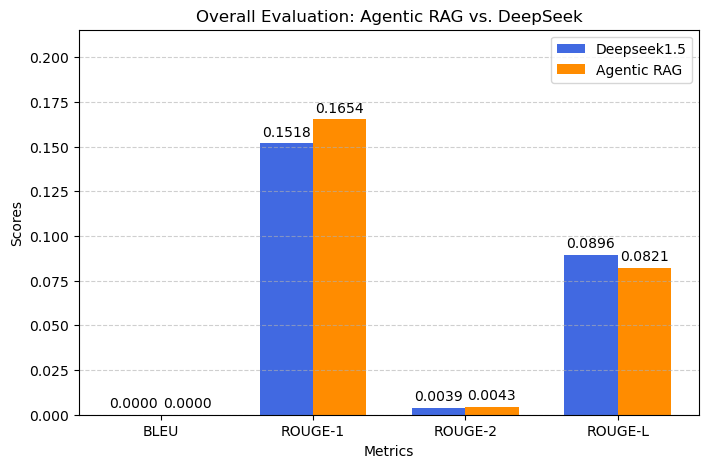

In [18]:
# Metrics for both models
metrics = ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
agentic_rag_scores = [0.0000, 0.1518, 0.0039, 0.0896]
deepseek_scores = [0.0000, 0.1654, 0.0043, 0.0821]

# X-axis positions
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, agentic_rag_scores, width, label="Deepseek1.5", color="royalblue")
bars2 = ax.bar(x + width/2, deepseek_scores, width, label="Agentic RAG", color="darkorange")

# Labels and title
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Overall Evaluation: Agentic RAG vs. DeepSeek")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.4f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(max(agentic_rag_scores), max(deepseek_scores)) )  # Adjust y-axis limit
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()

- ROUGE-1: AgenticRAG (0.1654) performs slightly better than DeepSeek (0.1518), indicating it captures more individual words from the reference summaries.
- ROUGE-2: AgenticRAG (0.0043) also slightly outperforms DeepSeek (0.0039) in capturing bi-grams.
- ROUGE-L: DeepSeek (0.0896) has a slight edge over AgenticRAG (0.0821) in preserving longer sequential structures from the reference text.

In [ ]:
def compute_content_fidelity(reference, candidate):
    """
    Content Fidelity (CF) can be defined as the percentage of keywords 
    from the original abstract that appear in the summary.
    Novelty can be computed as the percentage of unique keywords in the summary that do not appear in the original abstract
    """
    reference_keywords = set(reference.split())
    candidate_keywords = set(candidate.split())
    
    content_fidelity = len(reference_keywords & candidate_keywords) / len(reference_keywords)
    novelty = len(candidate_keywords - reference_keywords) / len(candidate_keywords)
    
    return content_fidelity, novelty


### ==Graph-RAG ==

In [ ]:
def query_graphrag(
    query: str,
    method: str = "global",
    root_path: str = "./ragtest",
    timeout: Optional[int] = None,
    community_level: int = 2,
    dynamic_community_selection: bool = False
) -> str:
    if community_level < 0:
        raise ValueError("Community level must be non-negative")

    command = [
        "python", "-m", "graphrag.query",
        "--root", root_path,
        "--method", method,
        "--community_level", str(community_level)
    ]

    if dynamic_community_selection:
        command.append("--dynamic-community-selection")

    command.append(query)

    try:
        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            timeout=timeout
        )
        result.check_returncode()
        return result.stdout.strip()

    except subprocess.CalledProcessError as e:
        print("=== STDOUT ===")
        print(e.stdout)
        print("=== STDERR ===")
        print(e.stderr)
        raise


In [ ]:
# Function to query GraphRAG and get the summary
def graphrag_summary(query: str) -> str:
    try:
        return query_graphrag(query)
    except Exception as e:
        print(f"Error querying GraphRAG: {e}")
        return "Error: Failed to generate summary from GraphRAG"


### ===Baseline Model Summary ===

In [ ]:
def baseline_model_summary(query: str) -> str:
    return reasoner.run(query) 

### === Evaluation Loop to compare between Baseline_Model , Classical-RAG , Agentic-RAG , Graph-RAG ===

In [ ]:
# Define the models for comparison
def evaluate_model(model_function, query, reference_summary):
    # Generate the summary using the model
    candidate_summary = model_function(query)
    
    # Compute BLEU & ROUGE scores
    bleu_score = compute_bleu(reference_summary, candidate_summary)
    rouge_score = compute_rouge(reference_summary, candidate_summary)
    
    # Compute Content Fidelity and Novelty
    content_fidelity, novelty = compute_content_fidelity(reference_summary, candidate_summary)
    
    return bleu_score, rouge_score, content_fidelity, novelty

# Define containers for the results
bleu_scores = {"Agentic_RAG": [], "Classical_RAG": [], "GraphRAG": [], "Baseline": []}
rouge_scores = {"Agentic_RAG": {"rouge1": [], "rouge2": [], "rougeL": []},
                "Classical_RAG": {"rouge1": [], "rouge2": [], "rougeL": []},
                "GraphRAG": {"rouge1": [], "rouge2": [], "rougeL": []},
                "Baseline": {"rouge1": [], "rouge2": [], "rougeL": []}}

content_fidelity_scores = {"Agentic_RAG": [], "Classical_RAG": [], "GraphRAG": [], "Baseline": []}
novelty_scores = {"Agentic_RAG": [], "Classical_RAG": [], "GraphRAG": [], "Baseline": []}

# Loop through the PDFs for evaluation
for pdf in pdf_files:
    print(f"Processing {pdf}...")

    # Extract reference summary (ground truth)
    reference_summary = extract_abstract(pdf)

    # Define the query for summarization
    query = "Summarize this paper in 200 words."

    # Evaluate Agentic RAG
    bleu_rag, rouge_rag, cf_rag, novelty_rag = evaluate_model(rag_with_reasoner, query, reference_summary)
    bleu_scores["Agentic_RAG"].append(bleu_rag)
    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["Agentic_RAG"][key].append(rouge_rag[key].fmeasure)
    content_fidelity_scores["Agentic_RAG"].append(cf_rag)
    novelty_scores["Agentic_RAG"].append(novelty_rag)

    # Evaluate Classical RAG
    bleu_classical_rag, rouge_classical_rag, cf_classical_rag, novelty_classical_rag = evaluate_model(classical_rag_summary, query, reference_summary)
    bleu_scores["Classical_RAG"].append(bleu_classical_rag)
    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["Classical_RAG"][key].append(rouge_classical_rag[key].fmeasure)
    content_fidelity_scores["Classical_RAG"].append(cf_classical_rag)
    novelty_scores["Classical_RAG"].append(novelty_classical_rag)

    # Evaluate GraphRAG
    bleu_graphrag, rouge_graphrag, cf_graphrag, novelty_graphrag = evaluate_model(graphrag_summary, query, reference_summary)
    bleu_scores["GraphRAG"].append(bleu_graphrag)
    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["GraphRAG"][key].append(rouge_graphrag[key].fmeasure)
    content_fidelity_scores["GraphRAG"].append(cf_graphrag)
    novelty_scores["GraphRAG"].append(novelty_graphrag)

    # Evaluate Baseline Model
    bleu_baseline, rouge_baseline, cf_baseline, novelty_baseline = evaluate_model(baseline_model_summary, query, reference_summary)
    bleu_scores["Baseline"].append(bleu_baseline)
    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["Baseline"][key].append(rouge_baseline[key].fmeasure)
    content_fidelity_scores["Baseline"].append(cf_baseline)
    novelty_scores["Baseline"].append(novelty_baseline)

    time.sleep(2)

# Print final evaluation results
for model in ["Agentic_RAG", "Classical_RAG", "GraphRAG", "Baseline"]:
    avg_bleu = sum(bleu_scores[model]) / len(bleu_scores[model])
    avg_rouge1 = sum(rouge_scores[model]["rouge1"]) / len(rouge_scores[model]["rouge1"])
    avg_rouge2 = sum(rouge_scores[model]["rouge2"]) / len(rouge_scores[model]["rouge2"])
    avg_rougeL = sum(rouge_scores[model]["rougeL"]) / len(rouge_scores[model]["rougeL"])
    avg_cf = sum(content_fidelity_scores[model]) / len(content_fidelity_scores[model])
    avg_novelty = sum(novelty_scores[model]) / len(novelty_scores[model])

    print(f"\n🔷 {model} Performance:")
    print(f"   🟢 Avg BLEU: {avg_bleu:.4f}")
    print(f"   🟢 Avg ROUGE-1: {avg_rouge1:.4f}")
    print(f"   🟢 Avg ROUGE-2: {avg_rouge2:.4f}")
    print(f"   🟢 Avg ROUGE-L: {avg_rougeL:.4f}")
    print(f"   🟢 Avg Content Fidelity: {avg_cf:.4f}")
    print(f"   🟢 Avg Novelty: {avg_novelty:.4f}")
